In [14]:
%load_ext autoreload
# for leonhard
import os
try:
    os.environ['XLA_FLAGS'] = "--xla_gpu_cuda_data_dir=" + os.environ["CUDA_HOME"]
except KeyError:
    pass

# Train a Bayesian neural network to classify MNIST using
# Neural SVGD
#
# If using pmap, set the environment variable
# `export XLA_FLAGS="--xla_force_host_platform_device_count=8"`
# before running on CPU (this enables pmap to "see" multiple cores).
import sys
import os
on_cluster = not os.getenv("HOME") == "/home/lauro"
if on_cluster:
    sys.path.append("/cluster/home/dlauro/projects-2020-Neural-SVGD/learning_particle_gradients/")
sys.path.append("../../experiments/")

import argparse
import matplotlib.pyplot as plt
from jax import vmap, random
import jax.numpy as jnp
import numpy as onp
from tqdm import tqdm
import optax
import bnn
import models
import metrics
import mnist
import config as cfg
import utils
from jax import jit, grad, value_and_grad
import json_tricks as json

# Config
key = random.PRNGKey(0)
MAX_TRAIN_STEPS = 100  # df 100
META_LEARNING_RATE = 5e-3  # df 1e-3; should be as high as possible; regularize w/ max steps
PATIENCE = 5  # df 5; early stopping not v helpful, bc we overfit on all ps

NUM_SAMPLES = 101
DISABLE_PROGRESS_BAR = False
USE_PMAP = False

BATCH_SIZE = 128
LAMBDA_REG = 100
STEP_SIZE = 2e-7 * LAMBDA_REG
PATIENCE = 20
MAX_TRAIN_STEPS = 50

import jax
from tensorflow_probability.substrates import jax as tfp
import uncertainty_metrics.numpy as um

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
!ls nvgd

params.npy  rundata.json


In [26]:
nvgd_rundata = json.load("nvgd/rundata.json")
svgd_rundata = json.load("svgd/rundata.json")
sgld_rundata = json.load("sgld/rundata.json")

In [33]:
sgld_rundata['accuracy'][-1]

[840.0, 0.9608662128448486]

In [34]:
svgd_rundata['accuracy'][-1]

[840.0, 0.9623622298240662]

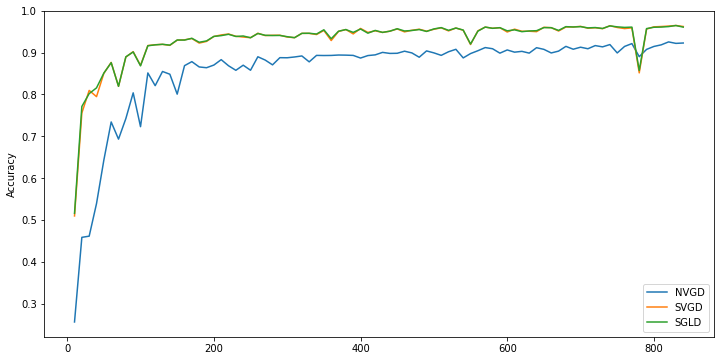

In [36]:
plt.subplots(figsize=[12, 6])
plt.plot(*zip(*nvgd_rundata['accuracy']), label="NVGD")
plt.plot(*zip(*svgd_rundata['accuracy']), label="SVGD")
plt.plot(*zip(*sgld_rundata['accuracy']), label="SGLD")
plt.ylabel("Accuracy")
plt.legend()

In [18]:
nvgd_rundata['accuracy'][-1]

[840.0, 0.9229198098182678]

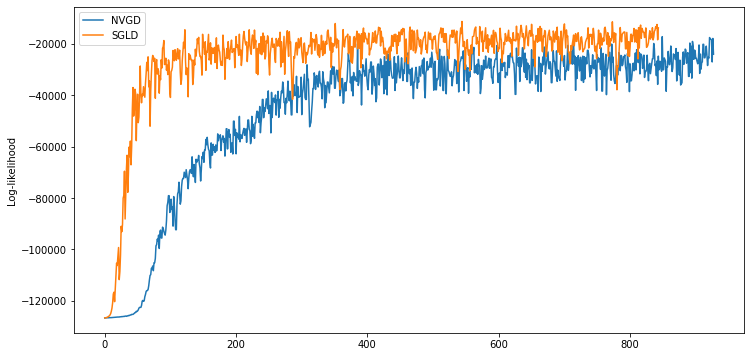

In [43]:
plt.subplots(figsize=[12, 6])
plt.plot(nvgd_rundata['loglikelihood'], label="NVGD")
# plt.plot(*zip(*svgd_rundata['accuracy']), label="SVGD")
plt.plot(sgld_rundata['loglikelihood'], label="SGLD")
plt.ylabel("Log-likelihood")
plt.legend()